In [1]:
import importlib
import train
import models
import fhe_vec

importlib.reload(train)
importlib.reload(models)
importlib.reload(fhe_vec)

from train import *
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch
import random
from fhe_vec import FHE_VEC
from models import *
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# IRIS Dataset

In [27]:
iris_train_ds, iris_test_ds = download_IRIS()

iris_model = Linear(4, 3).to(device)
train(iris_model, iris_train_ds, epochs=1000, learning_rate=1e-2)

start = time.time()
test(iris_model, iris_test_ds, batch_size=64)
end = time.time()

reg_time = end - start
print(f"Total runtime for FHE MNIST Model: {reg_time:.3f} seconds")

Epoch 1/1000, Training Loss: 1.1433
Validation Loss: 0.0486, Validation Accuracy: 0.2083
Epoch 2/1000, Training Loss: 1.1175
Validation Loss: 0.0469, Validation Accuracy: 0.2083
Epoch 3/1000, Training Loss: 1.1100
Validation Loss: 0.0453, Validation Accuracy: 0.5833
Epoch 4/1000, Training Loss: 1.0795
Validation Loss: 0.0441, Validation Accuracy: 0.6250
Epoch 5/1000, Training Loss: 1.0794
Validation Loss: 0.0433, Validation Accuracy: 0.6250
Epoch 6/1000, Training Loss: 1.0637
Validation Loss: 0.0427, Validation Accuracy: 0.6250
Epoch 7/1000, Training Loss: 1.0526
Validation Loss: 0.0423, Validation Accuracy: 0.6667
Epoch 8/1000, Training Loss: 1.0163
Validation Loss: 0.0421, Validation Accuracy: 0.6667
Epoch 9/1000, Training Loss: 1.0112
Validation Loss: 0.0420, Validation Accuracy: 0.6667
Epoch 10/1000, Training Loss: 1.0180
Validation Loss: 0.0418, Validation Accuracy: 0.6667
Epoch 11/1000, Training Loss: 0.9843
Validation Loss: 0.0418, Validation Accuracy: 0.6667
Epoch 12/1000, Trai

In [28]:
fhe = FHE_VEC()
fhe_iris_model = FHELinear(iris_model, fhe)

start = time.time()
test_fhe(fhe_iris_model, fhe, iris_test_ds, batch_size=64, scale=100)
end = time.time()

fhe_time = end - start
print(f"Total runtime for FHE MNIST Model: {fhe_time:.3f} seconds")

print(f" {fhe_time/reg_time}x Slow Down for FHE")

Got Batch!
Forwarding through model!
Decrypting output!
Test Accuracy: 1.0000, 30/30
Total runtime for FHE MNIST Model: 5.274 seconds
 5763.274361646691x Slow Down for FHE


# MNIST Dataset

/Users/kojikimura/miniconda3/envs/sage-diffusion2/lib/python3.12/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


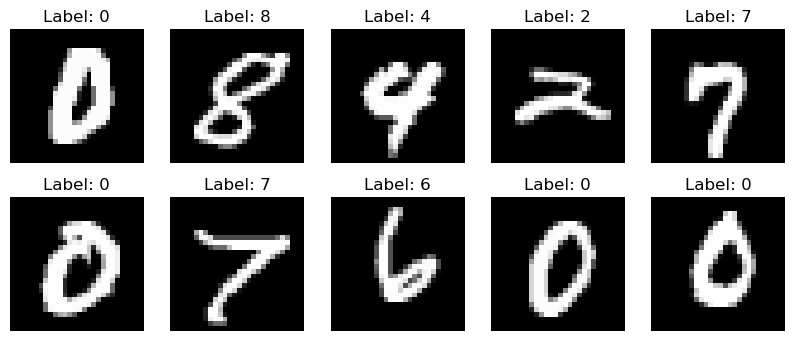

In [4]:
mnist_train_ds, mnist_test_ds = download_MNIST()
data_loader = DataLoader(mnist_test_ds, batch_size=64, shuffle=True)
images, labels = next(iter(data_loader))

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

In [5]:
mnist_model = Linear(28 * 28, 10).to(device)
train(mnist_model, mnist_train_ds, epochs=10, learning_rate=1e-2)
test(mnist_model, mnist_test_ds)

fhe = FHE_VEC(64)
fhe_mnist_model = FHELinear(mnist_model, fhe)

Epoch 1/10, Training Loss: 1.5879
Validation Loss: 0.0001, Validation Accuracy: 0.9161
Epoch 2/10, Training Loss: 1.5487
Validation Loss: 0.0001, Validation Accuracy: 0.9231
Epoch 3/10, Training Loss: 1.5406
Validation Loss: 0.0001, Validation Accuracy: 0.9243
Epoch 4/10, Training Loss: 1.5374
Validation Loss: 0.0001, Validation Accuracy: 0.9250
Epoch 5/10, Training Loss: 1.5344
Validation Loss: 0.0001, Validation Accuracy: 0.9267
Epoch 6/10, Training Loss: 1.5327
Validation Loss: 0.0001, Validation Accuracy: 0.9263
Epoch 7/10, Training Loss: 1.5310
Validation Loss: 0.0001, Validation Accuracy: 0.9273
Epoch 8/10, Training Loss: 1.5288
Validation Loss: 0.0001, Validation Accuracy: 0.9233
Epoch 9/10, Training Loss: 1.5282
Validation Loss: 0.0001, Validation Accuracy: 0.9265
Epoch 10/10, Training Loss: 1.5270
Validation Loss: 0.0001, Validation Accuracy: 0.9273
Test Accuracy: 0.9331, 9331/10000


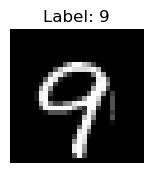

In [6]:
data_loader = DataLoader(mnist_test_ds, batch_size=64, shuffle=True)
images, labels = next(iter(data_loader))

plt.figure(figsize=(10, 4))
for i in range(1):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

In [18]:
i = 0
image = images[i]
label = labels[i]

start = time.time()

out = mnist_model(image.view(28*28)).detach().numpy()
pred = np.argmax(out).reshape(-1, 1)
end = time.time()

reg_time = end - start
print(f"Total runtime for MNIST Model: {reg_time:.3f} seconds")
pred

Total runtime for MNIST Model: 0.022 seconds


array([[9]])

In [19]:
i = 0
image = images[i]
label = labels[i]
SCALE = 10000
start = time.time()

scaled_image = scale_round(image.view(28*28), SCALE)
enc_data = fhe.encrypt(scaled_image)

print('Predicting...')
enc_out, out_scale = fhe_mnist_model(enc_data, SCALE)

out = fhe.decrypt(enc_out)

pred = np.argmax(out, axis=1).reshape(-1, 1)
end = time.time()

fhe_time = end - start
print(f"Total runtime for FHE MNIST Model: {fhe_time:.3f} seconds")


pred

Predicting...
Total runtime for FHE MNIST Model: 88.970 seconds


array([[9]])

In [20]:
print(f" {fhe_time/reg_time}x Slow Down for FHE")

 4106.805978033588x Slow Down for FHE
